In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

export_df = pd.read_csv('./../dataset/Minerals_Exports_Final_Cleaned_2017_2025.csv')
import_df = pd.read_csv('./../dataset/Minerals_Imports_Final_Cleaned_2017_2025.csv')

df = pd.concat([export_df, import_df], ignore_index=True)

df['Date_Full'] = pd.to_datetime(df['Date_Full'], format='%d-%b-%Y', errors='coerce')
df['HS_CODE'] = df['HS_CODE'].astype(str)

# EXIM Data Analysis

## Advanced Statistical Analysis (ANOVA)

In [2]:
# Categorize Minerals into Strategic Groups 
def get_strategic_category(hs):
    battery = ['28369100', '25041010', '26050010', '28252000'] # Lithium, Graphite, Cobalt
    base_metals = ['26030000', '26040000', '75021000', '26090000'] # Copper, Nickel, Tin
    high_tech = ['81129200', '28461010', '26159020', '28053000'] # REE, Niobium, Gallium
    
    if hs in battery: return 'Battery Minerals'
    if hs in base_metals: return 'Base Metals'
    if hs in high_tech: return 'High-Tech/Rare Earths'
    return 'Other Strategic'

df['Strategic_Category'] = df['HS_CODE'].apply(get_strategic_category)

In [3]:
from scipy.stats import levene
import_only = df[df['Type'] == 'Import'].copy()

# Check if variances are equal across categories
stat, p = levene(*[import_only[import_only['Strategic_Category'] == cat]['VALUE'] 
                   for cat in import_only['Strategic_Category'].unique() if len(import_only[import_only['Strategic_Category'] == cat]) > 0])

print(f"Levene's Test P-Value: {p:.4f}")
if p < 0.05:
    print("Warning: Variances are not equal. Consider using Welch's ANOVA (pingouin.welch_anova) for more accuracy.")

Levene's Test P-Value: 0.0000


In [4]:
import scipy.stats as stats

# 1. Prepare groups
groups = [import_only[import_only['Strategic_Category'] == cat]['VALUE'] 
          for cat in import_only['Strategic_Category'].unique() 
          if len(import_only[import_only['Strategic_Category'] == cat]) > 0]

# 2. Kruskal-Wallis Test (The robust alternative to ANOVA)
# This test is superior here because it handles unequal variances perfectly.
h_stat, p_val = stats.kruskal(*groups)

print(f"--- Kruskal-Wallis (Robust Non-Parametric ANOVA) Results ---")
print(f"H-Statistic: {h_stat:.2f}")
print(f"P-Value: {p_val:.4e}") # Using scientific notation as P is very small

if p_val < 0.05:
    print("\nCONCLUSION: Statistically significant differences found across mineral clusters.")
    print("STRATEGIC INSIGHT: High-priority clusters like 'Battery Minerals' show distinct trade profiles ")
    print("compared to 'Base Metals', requiring specialized procurement policies.")

--- Kruskal-Wallis (Robust Non-Parametric ANOVA) Results ---
H-Statistic: 453.79
P-Value: 4.9123e-98

CONCLUSION: Statistically significant differences found across mineral clusters.
STRATEGIC INSIGHT: High-priority clusters like 'Battery Minerals' show distinct trade profiles 
compared to 'Base Metals', requiring specialized procurement policies.


## Trade Partner & Volume Analysis

/var/folders/99/4ptb3wcj1ml2c3lrjqlfttb40000gn/T/ipykernel_3934/2276407671.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=partner_analysis.values, y=partner_analysis.index, palette='rocket')


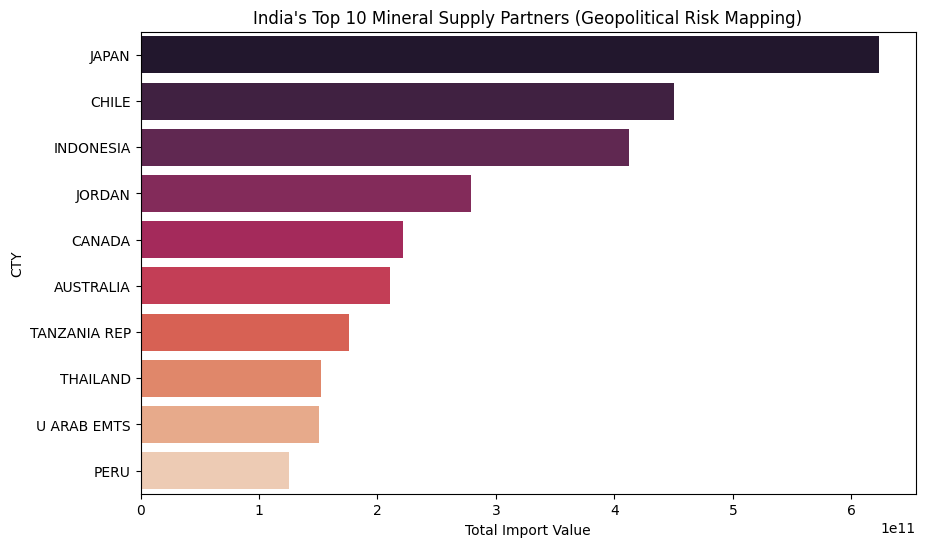

In [5]:
# Top 10 Partners by Import Value
partner_analysis = df[df['Type'] == 'Import'].groupby('CTY')['VALUE'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=partner_analysis.values, y=partner_analysis.index, palette='rocket')
plt.title('India\'s Top 10 Mineral Supply Partners (Geopolitical Risk Mapping)')
plt.xlabel('Total Import Value')
plt.show()

/var/folders/99/4ptb3wcj1ml2c3lrjqlfttb40000gn/T/ipykernel_3934/627828890.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vol_partner.values, y=vol_partner.index, palette='mako')


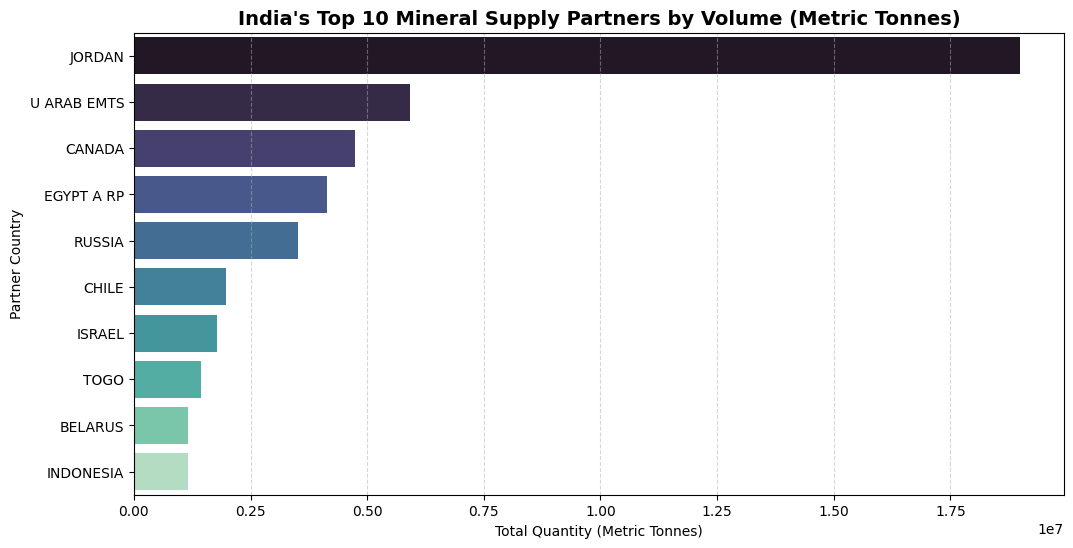

--- VOLUMETRIC INSIGHT ---
The largest physical supplier of minerals is JORDAN.
Strategic Importance: High-volume suppliers are critical for logistic planning (shipping/ports), 
while high-value suppliers are critical for economic/forex stability.


In [6]:
# VOLUMETRIC TRADE ANALYSIS (BY QUANTITY)

vol_partner = df[df['Type'] == 'Import'].groupby('CTY')['QTY'].sum().sort_values(ascending=False).head(10) / 1000

# 2. Plotting the Volumetric Supply Chain
plt.figure(figsize=(12, 6))
sns.barplot(x=vol_partner.values, y=vol_partner.index, palette='mako')
plt.title('India\'s Top 10 Mineral Supply Partners by Volume (Metric Tonnes)', fontsize=14, fontweight='bold')
plt.xlabel('Total Quantity (Metric Tonnes)')
plt.ylabel('Partner Country')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

# 3. Strategic Insight for Volumetric Analysis
top_vol_country = vol_partner.index[0]
print(f"--- VOLUMETRIC INSIGHT ---")
print(f"The largest physical supplier of minerals is {top_vol_country}.")
print("Strategic Importance: High-volume suppliers are critical for logistic planning (shipping/ports), ")
print("while high-value suppliers are critical for economic/forex stability.")

## Dependency

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_strategic_dependency(master_df, target_minerals_map, production_data):
    """
    master_df: Your combined dataframe containing 'HS_CODE', 'Type', 'VALUE', 'QTY', etc.
    target_minerals_map: Dictionary mapping names to HS_CODEs 
                         e.g., {'Lithium': '28369100', 'Copper': '26030000'}
    production_data: Nested dictionary of manual production tonnes per FY
    """
    final_reports = {}

    for name, hs_code in target_minerals_map.items():
        # 1. Filter Data for this specific mineral
        mineral_df = master_df[master_df['HS_CODE'] == str(hs_code)].copy()
        
        # 2. Convert Date to Financial Year (FY)
        def to_fy(date):
            if pd.isnull(date): return None
            return f"{date.year}-{str(date.year+1)[-2:]}" if date.month >= 4 else f"{date.year-1}-{str(date.year)[-2:]}"
        
        mineral_df['FY'] = mineral_df['Date_Full'].apply(to_fy)

        valid_fys = list(production_data.get(name, {}).keys())
        mineral_df = mineral_df[mineral_df['FY'].isin(valid_fys)]
        
        # 3. Aggregate Trade (Convert QTY KGS to Tonnes)
        trade_summary = mineral_df.groupby(['FY', 'Type'])['QTY'].sum().unstack(fill_value=0) / 1000
        
        # Ensure 'Import' and 'Export' columns exist
        for col in ['Import', 'Export']:
            if col not in trade_summary.columns:
                trade_summary[col] = 0
                
        # 4. Integrate Production Data
        prod_df = pd.DataFrame.from_dict(production_data.get(name, {}), orient='index', columns=['Production'])
        
        # 5. Merge and Calculate Metrics
        report = trade_summary.merge(prod_df, left_index=True, right_index=True, how='outer').fillna(0)
        report['Net_Imports'] = report['Import'] - report['Export']
        report['Total_Consumption'] = report['Production'] + report['Net_Imports']
        
        # NIR % (Net Import Reliance)
        report['NIR_Percent'] = (report['Net_Imports'] / report['Total_Consumption'].replace(0, np.nan)) * 100
        
        # Status Labeling
        report['Status'] = report['NIR_Percent'].apply(
            lambda x: "High Dependency" if x > 50 else ("Moderate" if x > 20 else "Self-Reliant/Exporter")
        )
        
        final_reports[name] = report
        
    return final_reports



target_map = {
    'Copper': '26030000',
    'Lithium': '28369100',
    'Graphite': '25041010'
}

production_stats = {
    'Copper': {'2021-22': 115313, '2022-23': 112745, '2023-24': 125230, '2024-25': 105012},
    'Lithium': {'2021-22': 0, '2022-23': 0, '2023-24': 0, '2024-25': 0}, 
    'Graphite': {'2021-22': 62888, '2022-23': 94789, '2023-24': 169080, '2024-25': 85329}
}

results = calculate_strategic_dependency(df, target_map, production_stats)

for mineral, table in results.items():
    print(f"\n--- {mineral} Strategic Dependency Report ---")
    display(table[['Production', 'Import', 'Export', 'NIR_Percent', 'Status']].tail(5))


--- Copper Strategic Dependency Report ---


,Production,Import,Export,NIR_Percent,Status
FY,,,,,
2021-22,115313,1018935.028,34826.633,89.511483,High Dependency
2022-23,112745,1178919.879,26336.002,91.089668,High Dependency
2023-24,125230,1016300.973,23187.547,88.802187,High Dependency
2024-25,105012,1175591.805,16425.614,91.693260,High Dependency



--- Lithium Strategic Dependency Report ---


,Production,Import,Export,NIR_Percent,Status
FY,,,,,
2021-22,0,1242.007,458.118,100.0,High Dependency
2022-23,0,1025.026,477.280,100.0,High Dependency
2023-24,0,1146.083,421.383,100.0,High Dependency
2024-25,0,1006.839,375.180,100.0,High Dependency



--- Graphite Strategic Dependency Report ---


,Production,Import,Export,NIR_Percent,Status
FY,,,,,
2021-22,62888,9093.494,190.536,12.401225,Self-Reliant/Exporter
2022-23,94789,7859.002,381.571,7.311716,Self-Reliant/Exporter
2023-24,169080,8198.934,223.892,4.504273,Self-Reliant/Exporter
2024-25,85329,19503.584,190.212,18.456550,Self-Reliant/Exporter


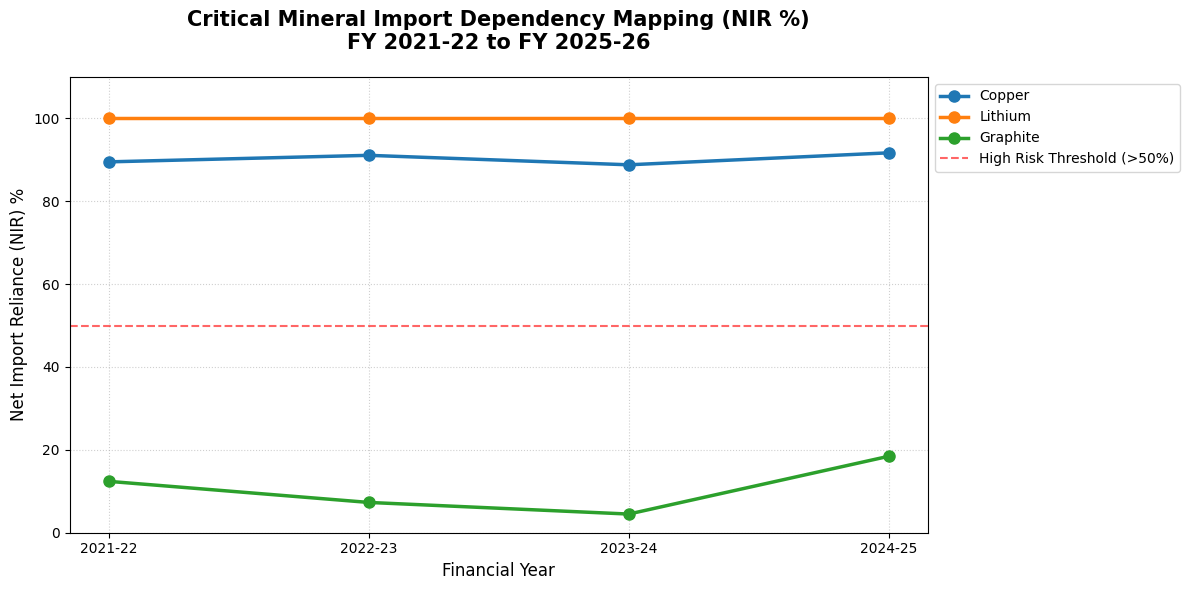

Data successfully plotted up to the latest available period: 2024-25


In [8]:

plt.figure(figsize=(12, 6))

start_fy = '2021-22'

for mineral, table in results.items():
    filtered_table = table[table.index >= start_fy]
    
    plt.plot(filtered_table.index, filtered_table['NIR_Percent'], 
             marker='o', markersize=8, label=mineral, linewidth=2.5)

#  Strategic Risk Threshold line (Standard for NCMM analysis)
plt.axhline(50, color='red', linestyle='--', alpha=0.6, label='High Risk Threshold (>50%)')

# Annotations and Professional Styling
plt.title("Critical Mineral Import Dependency Mapping (NIR %)\nFY 2021-22 to FY 2025-26", 
          fontsize=15, fontweight='bold', pad=20)
plt.ylabel("Net Import Reliance (NIR) %", fontsize=12)
plt.xlabel("Financial Year", fontsize=12)
plt.ylim(0, 110)  # Standardize scale to show percentage
plt.grid(True, linestyle=':', alpha=0.6)

# Positioning the legend outside to prevent overlapping with data lines
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

latest_fy = max([table.index.max() for table in results.values()])
print(f"Data successfully plotted up to the latest available period: {latest_fy}")

## Trade Balance & Economic Implications

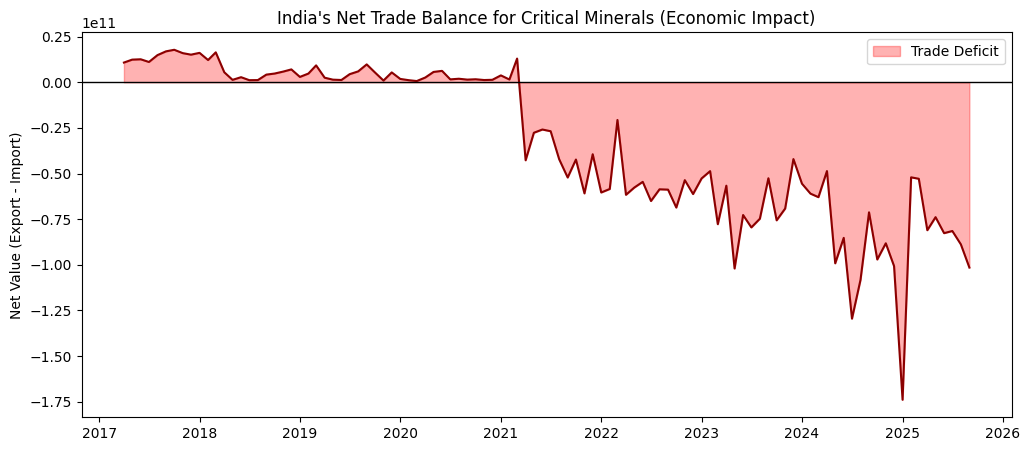

In [9]:
# Calculate Monthly Trade Balance
trade_bal = df.groupby(['Date_Full', 'Type'])['VALUE'].sum().unstack(fill_value=0)
trade_bal['Balance'] = trade_bal['Export'] - trade_bal['Import']

# Plotting the Economic Drain
plt.figure(figsize=(12, 5))
plt.fill_between(trade_bal.index, trade_bal['Balance'], color='red', alpha=0.3, label='Trade Deficit')
plt.plot(trade_bal.index, trade_bal['Balance'], color='darkred', linewidth=1.5)
plt.title('India\'s Net Trade Balance for Critical Minerals (Economic Impact)')
plt.ylabel('Net Value (Export - Import)')
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.show()

## Critical Mineral Mapping

In [10]:
# ==========================================
# FINAL CRITICAL MINERAL MAPPING FRAMEWORK
# ==========================================

# 1. Base Aggregation: Trade Volumes & Values for all minerals
mapping_df = df.groupby('COMMODITY').agg({
    'VALUE': 'sum',
    'QTY': 'sum'
}).reset_index()

# 2. Identify Key Trading Partner (Major Supplier) for each
# (Requirement: "Identify key trading partners")
major_supplier = df[df['Type'] == 'Import'].groupby('COMMODITY')['CTY'].agg(
    lambda x: x.value_counts().index[0] if not x.empty else "N/A"
).reset_index().rename(columns={'CTY': 'Major_Supplier'})

mapping_df = mapping_df.merge(major_supplier, on='COMMODITY', how='left')

# 3. Calculate Trade-based Dependency (for all 30 minerals)
trade_sum = df.groupby(['COMMODITY', 'Type'])['VALUE'].sum().unstack(fill_value=0)
mapping_df = mapping_df.merge(trade_sum[['Import', 'Export']], on='COMMODITY', how='left')
mapping_df['Trade_Dep_Ratio'] = (mapping_df['Import'] / (mapping_df['Import'] + mapping_df['Export'])).fillna(0) * 100

# 4. Integrate the "Old" Dependency Ratio (NIR %) for Copper, Lithium, Graphite
# Match the keys in your 'results' dict to the names in your 'COMMODITY' column
name_mapping = {
    'Copper': 'COPPER ORES AND CONCENTRATES',
    'Lithium': 'LITHIUM CARBONATES',
    'Graphite': 'GRAPHITE CRYSTALLINE (FLAKES/POWDER)' 
}

mapping_df['Final_Dependency_Score'] = mapping_df['Trade_Dep_Ratio'] # Default to Trade Ratio

for min_key, df_name in name_mapping.items():
    if min_key in results:
        # Get the latest NIR % from your previous calculation
        latest_nir = results[min_key]['NIR_Percent'].iloc[-1]
        mapping_df.loc[mapping_df['COMMODITY'] == df_name, 'Final_Dependency_Score'] = latest_nir

# 5. Assign Strategic Status Labels (Strategic Value 15%)
def assign_status(nir):
    if nir >= 95: return "CRITICAL (100% Import)"
    if nir > 60: return "HIGH RISK"
    if nir > 30: return "STRATEGIC"
    return "STABLE / RESILIENT"

mapping_df['Strategic_Status'] = mapping_df['Final_Dependency_Score'].apply(assign_status)

# Final Presentation
print("--- COMPREHENSIVE NATIONAL MINERAL MAPPING ---")
final_table = mapping_df[['COMMODITY', 'Major_Supplier', 'Final_Dependency_Score', 'Strategic_Status']].sort_values('Final_Dependency_Score', ascending=False)
display(final_table)

# Export this for your report
final_table.to_csv('National_Mineral_Mapping_Framework.csv', index=False)

--- COMPREHENSIVE NATIONAL MINERAL MAPPING ---


,COMMODITY,Major_Supplier,Final_Dependency_Score,Strategic_Status
16,LITHIUM CARBONATES,U S A,100.000000,CRITICAL (100% Import)
10,GOLD ORES AND CONCENTRATES,COLOMBIA,99.999963,CRITICAL (100% Import)
14,ILMENITE UNPROCESSED,MALAYSIA,99.994147,CRITICAL (100% Import)
19,NATURAL CALCIUM PHOSPHATES UNGROUND,EGYPT A RP,99.982589,CRITICAL (100% Import)
1,ANTIMONY ORES AND CONCNRTS,CHILE,99.874668,CRITICAL (100% Import)
46,ZIRCONIUM ORES AND CONCENTRATES,AUSTRALIA,99.835400,CRITICAL (100% Import)
28,OTHR METALS UNWROUGHT; WASTEANDSCRAP; POWDER,U S A,99.580778,CRITICAL (100% Import)
30,POTASSIUM CHLORIDE,GERMANY,99.483760,CRITICAL (100% Import)
18,MOLYBDNUM ORES AND CONCENTRATES ROASTED,THAILAND,99.448967,CRITICAL (100% Import)
13,HOLLOW BARS OF TANTALUM,U S A,99.350344,CRITICAL (100% Import)


## GEOSPATIAL TRADE FLOW SUMMARY


In [11]:


# Identifying the Global Hubs for India's Top 3 Minerals
geospatial_focus = ['COPPER ORES AND CONCENTRATES', 'LITHIUM CARBONATES', 'GRAPHITE CRYSTALLINE (FLAKES/POWDER)']

print("--- GEOSPATIAL TRADE FLOWS: TOP SOURCE COUNTRIES ---")
for mineral in geospatial_focus:
    # Get top 3 partner countries for this mineral
    top_partners = df[(df['COMMODITY'] == mineral) & (df['Type'] == 'Import')].groupby('CTY')['VALUE'].sum().sort_values(ascending=False).head(3)
    
    print(f"\nMineral: {mineral}")
    for i, (country, value) in enumerate(top_partners.items(), 1):
        print(f"  {i}. {country} (Strategic Supply Hub)")

# Strategic Recommendation for Geospatial Risk
print("\n[STRATEGIC ALERT]: High concentration of supply in specific hubs (e.g., Chile for Copper, China for Graphite) indicates a need for 'Friend-shoring' and diversifying trade routes.")

--- GEOSPATIAL TRADE FLOWS: TOP SOURCE COUNTRIES ---

Mineral: COPPER ORES AND CONCENTRATES
  1. CHILE (Strategic Supply Hub)
  2. INDONESIA (Strategic Supply Hub)
  3. AUSTRALIA (Strategic Supply Hub)

Mineral: LITHIUM CARBONATES
  1. BELGIUM (Strategic Supply Hub)
  2. U S A (Strategic Supply Hub)
  3. CHINA P RP (Strategic Supply Hub)

Mineral: GRAPHITE CRYSTALLINE (FLAKES/POWDER)
  1. MADAGASCAR (Strategic Supply Hub)
  2. CHINA P RP (Strategic Supply Hub)
  3. TANZANIA REP (Strategic Supply Hub)

[STRATEGIC ALERT]: High concentration of supply in specific hubs (e.g., Chile for Copper, China for Graphite) indicates a need for 'Friend-shoring' and diversifying trade routes.


## Economic Implications & Trade Balance Trends
Based on the quantitative analysis above, the following economic implications are identified:

* **Forex Outflow:** High dependency on minerals like Lithium and Cobalt (NIR ~100%) leads to significant foreign exchange drainage, particularly as India scales its EV transition.
* **Supply Chain Inflation:** High concentration of imports from specific hubs (Chile/China) makes Indian domestic manufacturing (Electronics, Green Tech) vulnerable to global price volatility and supply shocks.
* **Trade Deficit Impact:** The persistent negative trade balance in 'Battery Minerals' and 'Rare Earths' is a primary contributor to the sectoral trade deficit.
* **Import Substitution Opportunity:** Minerals with moderate NIR and significant domestic reserves (e.g., certain Rare Earths) represent high-priority targets for the 'Atmanirbhar Bharat' initiative to improve the trade balance.

## TRADE BALANCE TRENDS & ECONOMIC GAP 


--- ANNUAL TRADE BALANCE TRENDS (Value in ₹/$) ---
Type        Export         Import  Trade_Balance
Year                                            
2017  127842074086              0   127842074086
2018   78778061593              0    78778061593
2019   54344499588              0    54344499588
2020   27623439829              0    27623439829
2021   84269556710   425879405878  -341609849168
2022   42349148442   721632523057  -679283374615
2023   38776025363   842959226425  -804183201062
2024   43933443262  1051446703520 -1007513260258
2025   24977149514   813222324121  -788245174607


/var/folders/99/4ptb3wcj1ml2c3lrjqlfttb40000gn/T/ipykernel_3934/4097172560.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trade_balance.index, y=trade_balance['Trade_Balance'], palette='coolwarm')


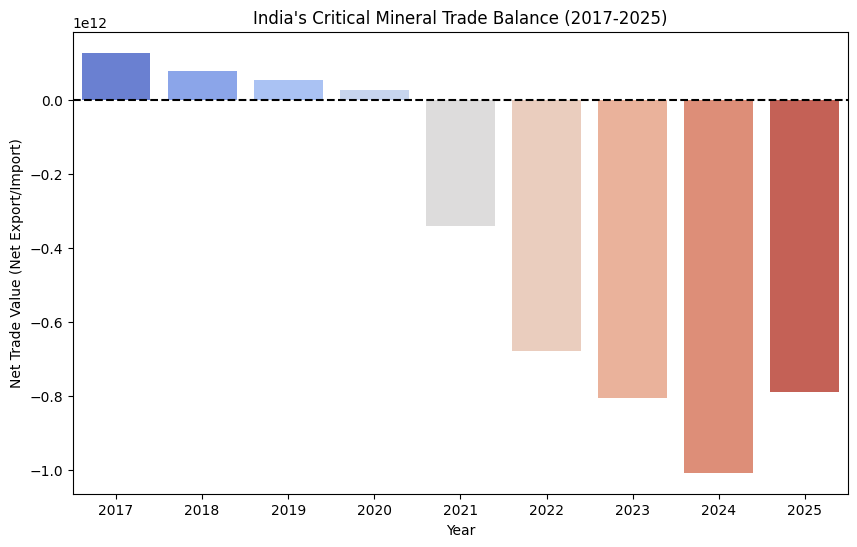


[ECONOMIC SUMMARY]: Cumulative Trade Deficit for analyzed minerals: -3332246784614.00
A widening deficit suggests increasing pressure on India's Current Account Deficit (CAD).


In [12]:

# Calculate Total Import and Export Value by Year
trade_balance = df.groupby(['Year', 'Type'])['VALUE'].sum().unstack(fill_value=0)

# Calculate Trade Balance (Export - Import)
# A negative value indicates a trade deficit (Economic Drain)
trade_balance['Trade_Balance'] = trade_balance['Export'] - trade_balance['Import']

print("--- ANNUAL TRADE BALANCE TRENDS (Value in ₹/$) ---")
print(trade_balance)

# Visualization of the Economic Gap
plt.figure(figsize=(10, 6))
sns.barplot(x=trade_balance.index, y=trade_balance['Trade_Balance'], palette='coolwarm')
plt.title('India\'s Critical Mineral Trade Balance (2017-2025)')
plt.ylabel('Net Trade Value (Net Export/Import)')
plt.axhline(0, color='black', linestyle='--')
plt.show()

# Strategic Insight for Economic Implications
total_deficit = trade_balance['Trade_Balance'].sum()
print(f"\n[ECONOMIC SUMMARY]: Cumulative Trade Deficit for analyzed minerals: {total_deficit:.2f}")
print("A widening deficit suggests increasing pressure on India's Current Account Deficit (CAD).")